<a href="https://colab.research.google.com/github/LucioFassarella/ComQ/blob/main/ComQ_Problema_CorteMaximo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema do Corte Máximo:

Resolução pela estratégia QAOA

## Instalação de pacotes e métodos

In [1]:
'''
Instalação do Qiskit e pacotes de visualização
'''
!pip install qiskit -U
!pip install qiskit_aer
!pip install qiskit-ibm-runtime

import qiskit
qiskit.__version__

!pip install matplotlib
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently

In [2]:
'''
Pacotes e Métodos
'''

# NumPy e SciPy
import numpy as np
import scipy as sp

# Minimizador do SciPy
from scipy.optimize import minimize

# Métodos do Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit.circuit.library import QAOAAnsatz

# Estimadores do Qiskit
from qiskit_aer.primitives import Estimator # <-- Estimator para simulação clássica
from qiskit_ibm_runtime import EstimatorV2 as Estimator # <-- Estimator para computação quântica
from qiskit_ibm_runtime import SamplerV2 as Sampler # <-- Estimator para computação quântica

# Qiskit Runtime
#from qiskit_ibm_runtime import QiskitRuntimeService, Session

import time

In [16]:
'''
Métodos para execução da estratégia QAOA
'''

# Conecção com a IBM

token_privado = "..." # <-- Inserir token privado na IBM
instance_do_projeto = "..." # <-- Inserir instance do projeto

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token = token_privado,
    instance = instance_do_projeto
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Importação do Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Importação do Sampler
## Simulação local
from qiskit.primitives import StatevectorSampler # For local simulation
sampler = StatevectorSampler()
## Simulação na IBM:
#from qiskit_ibm_runtime import SamplerV2
# sampler = SamplerV2(mode = backend)

# Transpilador

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

## Definição de métodos específicos

In [4]:
def Hamiltoniano_Corte(num_vertices = 'int', pesos = 'list'):
    '''
    Função que contrói o Hamiltoniano de corte para um grafo.

    Entradas:
        n: número de qubits (int)
        w: matriz de pesos (list)

    Saída:
        HC: Hamiltoniano do corte (SparsePauliOp)

    Método requerido:
        from qiskit.quantum_info import SparsePauliOp

    '''

    '''
    ### Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento 'num_vertices' deve ser um inteiro positivo")
    if type(pesos) != list:
        return print("O segundo argumento 'pesos' deve ser uma lista quadrada simétrica")
    if num_vertices != len(pesos):
        return print("O comprimento da lista 'pesos' deve ser igual ao primeiro argumento 'num_vertices'")

    '''
    ### Código principal
    '''

    operadores = []

    peso_total = 0
    for j in range(num_vertices):
        for i in range(j):
            peso_total += pesos[i][j]

    operadores.append(("I",[0], peso_total/2))

    for j in range(num_vertices):
        for i in range(j):
            operadores.append(("ZZ",[i,j], -pesos[i][j]/2))

    HC = SparsePauliOp.from_sparse_list(operadores, num_qubits = num_vertices)

    return HC

In [5]:
def Operador_Separador(num_vertices = 'int', pesos = 'list', gama = 'float'):
    '''
    Função que contrói o operador separador da estratégia QAOA para um grafo.

    Entradas:
        n: número de qubits (int)
        w : matriz de pesos (list)
        g: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento deve ser um inteiro")
    if type(pesos) != list:
        return print("O segundo argumento deve ser uma lista quadrada simétrica")
    if num_vertices != len(pesos):
        return print("O comprimento da lista deve ser igual ao primeiro argumento")

    '''
    Código principal
    '''

    qc = QuantumCircuit(num_vertices, name = "H_P")

    for j in range(num_vertices):
        for i in range(j):
            qc.rzz(gama*pesos[i][j],i,j)

    return qc

In [6]:
def Operador_Misturador(num_vertices = 'int', beta = 'float'):
    '''
    Função que contrói o operador misturador da estratégia QAOA para um grafo.

    Entradas:
        num_vertices: número de qubits (int)
        beta: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento deve ser um inteiro")

    '''
    Código principal
    '''

    qc = QuantumCircuit(num_vertices, name = "H_M")

    for i in range(num_vertices):
            qc.rx(beta,i)

    return qc

In [7]:
def QAOA_Ansatz(num_vertices = 'int', pesos = 'list', p = 'int', gama_vec = 'list', beta_vec = 'list'):
    '''
    Função que contrói o circuito quântico QAOA para um grafo.

    Entradas:
        num_vertices: número de qubits (int)
        pesos : matriz de pesos (list)
        gama_vec: lista de parâmetros reais (float)
        beta_vec: lista de parâmetros reais (float)

    Saída:
        qc: circuito quântico parametrizado com n qubits.

    Métodos requeridos:
        Hamiltoniano_Corte
        Operador_Separador
        Operador_Misturador

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''
    if type(num_vertices) != int:
        return print("O primeiro argumento 'num_vertices' deve ser um inteiro.")
    if type(pesos) != list:
        return print("O segundo argumento 'pesos' deve ser uma lista quadrada simétrica.")
    if num_vertices != len(pesos):
        return print("O comprimento da lista 'pesos' deve ser igual ao primeiro argumento 'num_vertices'.")
    if type(p) != int:
        return print("O terceiro argumento 'p' deve ser um inteiro.")
    if type(gama_vec) != list:
        return print("O quarto argumento 'gama_vec' deve ser uma lista de floats.")
    if type(beta_vec) != list:
        return print("O quinto argumento 'beta_vec' deve ser uma lista de floats.")
    if len(gama_vec) != p or len(beta_vec) != p:
        return print("Os parâmetros 'gama_vec' e 'beta_vec' devem ter comprimento igual ao terceiro argumento 'p'.")

    '''
    Código principal
    '''

    # Construção do circuito
    qc = QuantumCircuit(num_vertices, name = "QAOA_Ansatz")

    for i in range(num_vertices):
        qc.h(i)

    qubits = range(num_vertices)
    for i in range(p):
        qc.append(Operador_Separador(num_vertices, pesos, gama_vec[i]), qubits)
        qc.append(Operador_Misturador(num_vertices, beta_vec[i]), qubits)

    return qc

In [8]:
def CorteQ(parametros = 'list', num_vertices = 'int', pesos = 'list', p = 'int', estimator = 'qiskit_aer.primitives'):
    '''
    Função que retorna o corte de uma partição do grafo

    Entradas:
        estimator: estimador quântico (Estimator)
        num_vertices: número de qubits (int)
        pesos: matriz de pesos (list)
        p: profundidade do ansatz QAOA (int)
        parametros: 'gama_vec + beta_vec' = lista de parâmetros combinando parâmetros de separação e  parâmetros de mistura

    Saída:
        cost = float: custo

    Métodos requeridos:
        QAOA_Ansatz
        Estimator
        pass_manager: Qiskit PassManager

    Observações:
        Para executar esta função, é necessário previamente definir o "estimator"
        e inicializar o transpilador pelo comando
        "pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)"
    '''
    # Construção do circuito QAOA
    gama_vec = list(parametros[:p])
    beta_vec = list(parametros[p:])
    QAOA = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

    # Cálculo do corte
    QAOA_transpilado = pass_manager.run(QAOA)
    HC = Hamiltoniano_Corte(num_vertices, pesos)
    HC_transpilado = HC.apply_layout(QAOA_transpilado.layout)
    job = estimator.run([(QAOA_transpilado, HC_transpilado)])
    corte = job.result()[0].data.evs

    return corte

In [9]:
'''
Funções auxiliares para pós-processamento

(Elas definem representações de inteiros em base arbitrária e vice-versa)
'''

# Função que calcula o corte máximo de um grafo
def MaxCut(num_vertices, pesos):
    '''
    Função que calcula o corte máximo de uma partição de um grafo

    Entradas:
        num_vertices (int): número de vértices do grafo
        pesos (list): matriz de pesos do grafo

    Saída:
        corte_max (float): corte máximo do grafo
        particao_max (lista): lista com a partição de corte máxima:  [Amax,Bmax]
    '''
    corte_max = 0
    for p in range(2**num_vertices):
        A = []
        B = []
        for k in range(num_vertices):
            if (p // 2**k) % 2 == 1:
                A.append(k)
            else:
                B.append(k)
        corte = Corte(pesos,A)
        if corte > corte_max:
            corte_max = corte
            particao_max = [A,B]
    return corte_max, particao_max

# Função que calcula o corte de uma partição de um grafo
def Corte(pesos,A):
    '''
    Função que calcula o corte de uma partição de um grafo

    Entradas:
        pesos: matriz de pesos (list)
        A: lista de vértices da partição

    Saída:
        corte: corte da partição (float)
    '''

    num_vertices = len(pesos)
    corte = 0
    for i in range(num_vertices):
        for j in range(i):
            if (i in A and j not in A) or (j in A and i not in A):
                corte += pesos[i][j]

    return corte

# Função que retorna o estado da base computacional mais proeminente de um estado gerado por um circuito quântico
def estado_base_max(qc, num_qubits):
    '''
    Determina o estado da base computacional que tem maior probabilidade no estado
     gerado por um circuito quântico 'qc' num registro quântico com 'num_qubits' qubits.

    Entradas:
        qc (QuantumCircuit): circuito quântico
        num_qubits (int): número de qubits do circuito

    Saída:
        string: o estado da base com maior probabilidade, na forma de string binária

    Métodos:
        qiskit.QuantumCircuit
        qiskit.quantum_info.Statevector
        numpy as np
    '''

    estado = Statevector.from_instruction(qc)
    probabilidades = estado.probabilities()
    estado_base_maximo = np.argmax(probabilidades)
    return format(estado_base_maximo, f'0{num_qubits}b')

## Exemplos

### Exemplo 1: Grafo com 5 vértices

Dimensão do grafo: 5
Matriz de pesos:


[[0, 1, 0, 0, 1],
 [1, 0, 1, 0, 1],
 [0, 1, 0, 1, 0],
 [0, 0, 1, 0, 1],
 [1, 1, 0, 1, 0]]

Grafo:


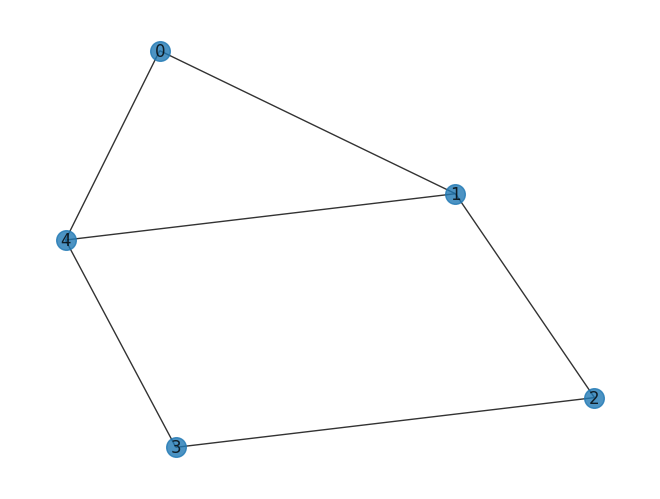

In [17]:
'''
Grafo
'''

num_vertices = 5
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0,1,0,0,1],
   [1,0,1,0,1],
   [0,1,0,1,0],
   [0,0,1,0,1],
    [1,1,0,1,0]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [18]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 5
Partição de corte máxima: [[1, 3], [0, 2, 4]]


In [19]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Estimador
estimator = Estimator()

# Inicialização dos parâmetros

parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais aleatórios: {parametros_iniciais}")
corte_0 = CorteQ(parametros_iniciais, num_vertices, pesos, p, estimator)
print(f"Corte inicial : {corte_0}")

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)

parametros = parametros_iniciais
corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYQA")

parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal

print(f"Parâmetros finais: {parametros_max}")
print(f"Corte máximo: {corte_max}")

print(f"Processo bem sucedido?: {corte.success}")
print(f"Mensagem do Cobyqa: {corte.message}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [0.8470489204005219, 1.6357120885222842, 4.267830199085368, 2.1630341742247006, 2.687173919760339, 3.8667128130067594, 1.1472341237720816, 6.1435742445688275]
Parâmetros iniciais aleatórios: [4.74966706786257, 5.188456345349415, 0.5769579137031432, 3.2324132388488693, 3.3750329159765498, 1.0685900579148724, 2.85441404341691, 5.681225869146986]
Corte inicial : 3.7499616970289553
Parâmetros finais: [5.83615902 4.95235175 0.24678562 1.86249747 4.26255722 2.3751776
 1.31115175 6.06916094]
Corte máximo: 4.7992364555876605
Processo bem sucedido?: True
Mensagem do Cobyqa: The lower bound for the trust-region radius has been reached
Tempo de execução: 0.8815977414449055 minutos


In [20]:
'''
Pós-processamento com o Estimator
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 01010
Corte Máximo: 5. Partição de corte máximo: ([1, 3], [0, 2, 4])


In [22]:
'''
Pós-processamento com o Sampler
'''

# Circuito

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)
# Adicionando registros clássicos e medida:
circ_medido = circ.measure_all(inplace=False) # 'inplace=False' porque o circuito não possui registros clássicos

#Preparação do PUB
parametros_pub = None
pubs = [(circ_medido, parametros_pub)]

#Execução do Sampler
job = sampler.run(pubs)

# Resultado:
print('Resultado do Sampler:')
result = job.result()
resultado = result[0].data['meas'].get_counts()
print(resultado)

lista_bits = list(resultado.keys())
lista_valores = list(resultado.values())

estado_maxcut = lista_bits[np.argmax(np.abs(lista_valores))]
print(estado_maxcut)

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Resultado do Sampler:
{'01011': 214, '01010': 226, '10010': 46, '11010': 23, '10100': 211, '10101': 189, '01101': 40, '00101': 16, '01001': 19, '10110': 28, '11100': 4, '00011': 2, '01100': 2, '01110': 1, '10001': 2, '11111': 1}
01010
Corte Máximo: 5. Partição de corte máximo: ([1, 3], [0, 2, 4])


### Exemplo 2: Grafo com subgrafos de 5 vértices

Dimensão do grafo: 10
Matriz de pesos:


[[0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0]]

Grafo:


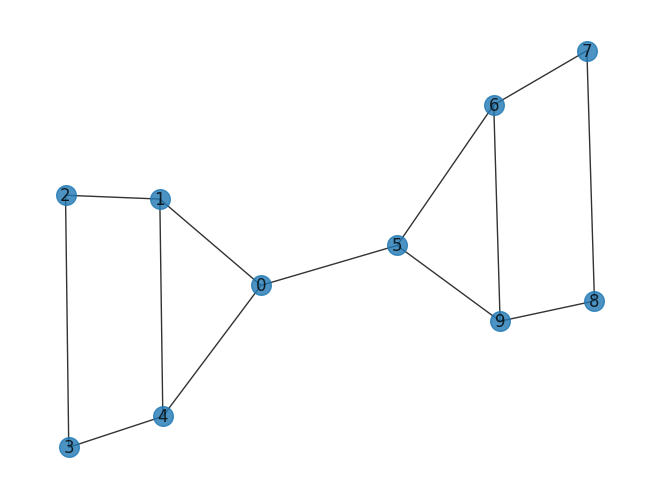

In [23]:
'''
Grafo
'''

num_vertices = 10
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0,1,0,0,1,1,0,0,0,0],
   [1,0,1,0,1,0,0,0,0,0],
   [0,1,0,1,0,0,0,0,0,0],
   [0,0,1,0,1,0,0,0,0,0],
   [1,1,0,1,0,0,0,0,0,0],
   [1,0,0,0,0,0,1,0,0,1],
   [0,0,0,0,0,1,0,1,0,1],
   [0,0,0,0,0,0,1,0,1,0],
   [0,0,0,0,0,0,0,1,0,1],
    [0,0,0,0,0,1,1,0,1,0]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [24]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 11
Partição de corte máxima: [[0, 1, 3, 6, 8], [2, 4, 5, 7, 9]]


In [25]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Estimador
estimator = Estimator()

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
corte_0 = CorteQ(parametros_iniciais, num_vertices, pesos, p, estimator)
print(f"Parâmetros iniciais: {parametros_iniciais}")
print(f"Corte inicial : {corte_0}")

corte = minimize(neg_CorteQ, parametros_iniciais, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYQA")

parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte máximo: {corte_max}")
print(f"Processo bem sucedido?: {corte.success}")
print(f"Mensagem do Cobyqa: {corte.message}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [5.32631387968224, 0.23437375777396385, 4.761077786714963, 2.174244532672193, 1.0492663001204283, 0.606401094337314, 0.3361664601279468, 1.549822269317333]
Corte inicial : 6.127049559696932
Parâmetros finais: [ 5.8671408  -0.84121824  5.20151358  1.59162803  1.07875738  0.87256725
  0.36687241  2.95647864]
Corte máximo: 10.556811321517428
Processo bem sucedido?: True
Mensagem do Cobyqa: The lower bound for the trust-region radius has been reached
Tempo de execução: 3.2395902276039124 minutos


In [28]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)
estado = Statevector.from_instruction(circ)
display(estado.draw('latex'))
print(estado.probabilities())

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

<IPython.core.display.Latex object>

[5.68684328e-07 6.02935272e-07 1.51220118e-07 ... 1.51220118e-07
 6.02935272e-07 5.68684328e-07]
Estado-base de corte máximo: 1010101010
Corte Máximo: 11. Partição de corte máximo: ([0, 2, 4, 6, 8], [1, 3, 5, 7, 9])


In [30]:
'''
Pós-processamento com o Sampler
'''

# Circuito

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)
# Adicionando registros clássicos e medida:
circ_medido = circ.measure_all(inplace=False) # 'inplace=False' porque o circuito não possui registros clássicos

#Preparação do PUB
parametros_pub = None
pubs = [(circ_medido, parametros_pub)]

#Execução do Sampler
job = sampler.run(pubs)

# Resultado:
print('Resultado do Sampler:')
result = job.result()
resultado = result[0].data['meas'].get_counts()
print(resultado)

lista_bits = list(resultado.keys())
lista_valores = list(resultado.values())

estado_maxcut = lista_bits[np.argmax(np.abs(lista_valores))]
print(estado_maxcut)

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Resultado do Sampler:
{'1010010101': 80, '1010001011': 81, '0101001001': 11, '1010110100': 88, '1001010101': 15, '0101110001': 1, '0101110100': 80, '0101000101': 10, '0101010101': 89, '0100110100': 13, '0101001011': 79, '0010110100': 16, '0101111010': 12, '1010010100': 2, '0110101010': 12, '1011001101': 2, '0101101010': 84, '1010111010': 8, '1010000101': 6, '1001001011': 21, '1010001101': 12, '0101110010': 21, '1010101010': 98, '0100101010': 8, '1010110010': 15, '1011001011': 8, '1101010101': 7, '0010101010': 7, '0101010100': 1, '1010110110': 6, '1011010101': 12, '1101001101': 3, '1101000101': 2, '0000001010': 1, '0110110100': 15, '1010111100': 1, '0110111110': 1, '1010100010': 2, '0000010101': 1, '1010001001': 6, '0101001101': 9, '1111110100': 1, '1101001001': 1, '0001001011': 1, '0100110101': 1, '1010101011': 4, '1001001101': 4, '1010010000': 1, '1010110101': 2, '0100101011': 1, '1101001011': 6, '1000101101': 1, '0100101001': 1, '0010010100': 1, '0100010011': 1, '1010001010': 1, '101

### Exemplo 3: Grafo com 12 vértices

Dimensão do grafo: 12
Matriz de pesos:


[[0, 5, -2, 3, 1, -4, 2, -1, 6, 4, -3, 0],
 [5, 0, 4, -1, 2, 3, -2, 1, -5, 0, 2, -1],
 [-2, 4, 0, 2, -3, 1, 5, 0, 3, -2, 1, 4],
 [3, -1, 2, 0, 4, 1, -2, 5, 0, 2, 3, -1],
 [1, 2, -3, 4, 0, -2, 1, 3, -1, 5, 0, 2],
 [-4, 3, 1, 1, -2, 0, 4, -3, 2, 1, 5, -2],
 [2, -2, 5, -2, 1, 4, 0, 3, 2, 1, -4, 3],
 [-1, 1, 0, 5, 3, -3, 3, 0, 1, 2, 4, -2],
 [6, -5, 3, 0, -1, 2, 2, 1, 0, 4, -3, 1],
 [4, 0, -2, 2, 5, 1, 1, 2, 4, 0, 3, -2],
 [-3, 2, 1, 3, 0, 5, -4, 4, -3, 3, 0, 1],
 [0, -1, 4, -1, 2, -2, 3, -2, 1, -2, 1, 0]]

Grafo:


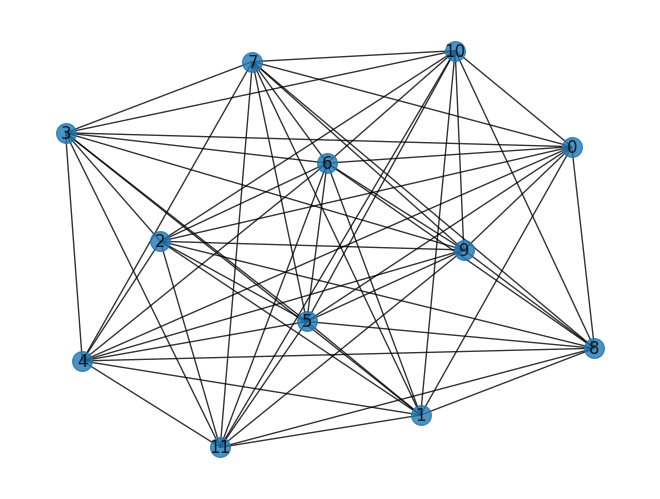

In [31]:
'''
Grafo
'''

num_vertices = 12
print(f"Dimensão do grafo: {num_vertices}")


pesos = [
    [ 0,  5, -2,  3,  1, -4,  2, -1,  6,  4, -3,  0],
    [ 5,  0,  4, -1,  2,  3, -2,  1, -5,  0,  2, -1],
    [-2,  4,  0,  2, -3,  1,  5,  0,  3, -2,  1,  4],
    [ 3, -1,  2,  0,  4,  1, -2,  5,  0,  2,  3, -1],
    [ 1,  2, -3,  4,  0, -2,  1,  3, -1,  5,  0,  2],
    [-4,  3,  1,  1, -2,  0,  4, -3,  2,  1,  5, -2],
    [ 2, -2,  5, -2,  1,  4,  0,  3,  2,  1, -4,  3],
    [-1,  1,  0,  5,  3, -3,  3,  0,  1,  2,  4, -2],
    [ 6, -5,  3,  0, -1,  2,  2,  1,  0,  4, -3,  1],
    [ 4,  0, -2,  2,  5,  1,  1,  2,  4,  0,  3, -2],
    [-3,  2,  1,  3,  0,  5, -4,  4, -3,  3,  0,  1],
    [ 0, -1,  4, -1,  2, -2,  3, -2,  1, -2,  1,  0]
]

print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [32]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 76
Partição de corte máxima: [[1, 3, 6, 8, 10], [0, 2, 4, 5, 7, 9, 11]]


In [34]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Estimador
estimator = Estimator()

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
corte_0 = CorteQ(parametros_iniciais, num_vertices, pesos, p, estimator)
print(f"Parâmetros iniciais: {parametros_iniciais}")
print(f"Corte inicial : {corte_0}")

corte = minimize(neg_CorteQ, parametros_iniciais, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYQA")

parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte máximo: {corte_max}")
print(f"Processo bem sucedido?: {corte.success}")
print(f"Mensagem do Cobyqa: {corte.message}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [5.101025283756181, 4.140097285944784, 3.934785106630171, 2.9283868832073043, 0.03517702121019232, 4.611370221271093, 5.836151287909175, 5.051528227853028]
Corte inicial : 33.403896953370605
Parâmetros finais: [ 5.05792015  4.23775316  3.88759609  2.92693437 -0.00564775  3.94221372
  5.48414245  5.42812074]
Corte máximo: 35.136781435516696
Processo bem sucedido?: True
Mensagem do Cobyqa: The lower bound for the trust-region radius has been reached
Tempo de execução: 12.946663761138916 minutos


In [37]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 000101011011
Corte Máximo: 33. Partição de corte máximo: ([3, 5, 7, 8, 10, 11], [0, 1, 2, 4, 6, 9])


In [39]:
'''
Pós-processamento com o Sampler
'''

# Circuito

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)
# Adicionando registros clássicos e medida:
circ_medido = circ.measure_all(inplace=False) # 'inplace=False' porque o circuito não possui registros clássicos

#Preparação do PUB
parametros_pub = None
pubs = [(circ_medido, parametros_pub)]

#Execução do Sampler
job = sampler.run(pubs)

# Resultado:
print('Resultado do Sampler:')
result = job.result()
resultado = result[0].data['meas'].get_counts()
print(resultado)

lista_bits = list(resultado.keys())
lista_valores = list(resultado.values())

estado_maxcut = lista_bits[np.argmax(np.abs(lista_valores))]
print(estado_maxcut)

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Resultado do Sampler:
{'101101101100': 1, '110111110000': 1, '110110010110': 3, '000101010110': 1, '111101001011': 3, '101001011110': 1, '011111101101': 3, '001100110100': 2, '111010010110': 1, '011001111000': 2, '010010001101': 1, '100100001011': 2, '110111100101': 1, '000110011000': 1, '010000011101': 2, '000011110000': 1, '000110001100': 4, '011010100010': 2, '010101001011': 1, '010100110001': 2, '100101001010': 1, '010001101100': 2, '001110110010': 1, '010101100010': 1, '100110100111': 1, '101011011000': 1, '110110111011': 1, '100110010100': 1, '011000001101': 1, '110001101010': 1, '110001010001': 2, '011000011100': 1, '111110000010': 2, '001110011010': 4, '100011110000': 1, '111010100100': 5, '000010000001': 1, '000110011101': 1, '101100111000': 1, '101011001110': 4, '000101000010': 1, '100001110111': 2, '011111001100': 3, '101110011100': 1, '001011001011': 2, '110011011111': 1, '000110100110': 1, '010110111000': 3, '111010111101': 1, '110111010010': 1, '100011101111': 3, '1101100

### Exemplo: Grafo com 14 vértices e pesos variáveis

Dimensão do grafo: 14
Matriz de pesos:


[[0.0, 0.36, 0.47, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.36, 0.0, 0.0, 0.0, 0.16, 0.0, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.47, 0.0, 0.0, 0.37, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.14, 0.0, 0.37, 0.0, 0.0, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.16, 0.0, 0.0, 0.0],
 [0.0, 0.69, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.19, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.66, 0.0, 0.0, 0.0, 0.52],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, 0.66, 0.0, 0.0, 0.43, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.15],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.76, 0.0, 0.43, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19, 0.0, 0.0, 0.76, 0.0, 0.0, 0.38],
 [0.0, 0.0, 0.0,

Grafo:


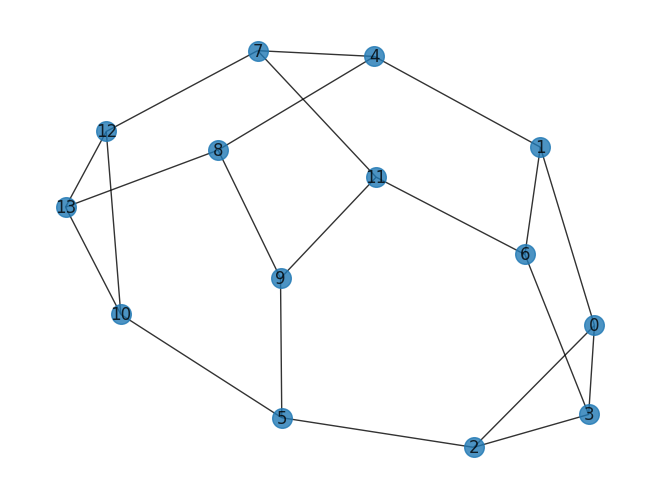

In [40]:
'''
Grafo
'''

num_vertices = 14
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0.00,0.36,0.47,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.36,0.00,0.00,0.00,0.16,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.47,0.00,0.00,0.37,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.14,0.00,0.37,0.00,0.00,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.82,0.70,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.90,0.16,0.00,0.00,0.00],
   [0.00,0.69,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.19,0.00],
   [0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.52],
   [0.00,0.00,0.00,0.00,0.00,0.90,0.00,0.00,0.66,0.00,0.00,0.43,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.15],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.76,0.00,0.43,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.76,0.00,0.00,0.38],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.00,0.15,0.00,0.38,0.00]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [41]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 9.53
Partição de corte máxima: [[0, 5, 6, 7, 8, 12], [1, 2, 3, 4, 9, 10, 11, 13]]


In [42]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Estimador
estimator = Estimator()

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
corte_0 = CorteQ(parametros_iniciais, num_vertices, pesos, p, estimator)
print(f"Parâmetros iniciais: {parametros_iniciais}")
print(f"Corte inicial : {corte_0}")

corte = minimize(neg_CorteQ, parametros_iniciais, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYQA")

parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte máximo: {corte_max}")
print(f"Processo bem sucedido?: {corte.success}")
print(f"Mensagem do Cobyqa: {corte.message}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [1.5219541346420804, 0.8917257880252133, 1.4323571955030154, 3.959322009582146, 5.565637949702166, 4.325551603707906, 3.4959246874448517, 5.125882577438799]
Corte inicial : 5.150964944122702
Parâmetros finais: [1.87822825 2.17313231 1.22873444 3.70883587 6.47065496 4.81635909
 3.00787188 5.43936317]
Corte máximo: 6.255640976311665
Processo bem sucedido?: True
Mensagem do Cobyqa: The lower bound for the trust-region radius has been reached
Tempo de execução: 5.240559319655101 minutos


In [43]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 01011001010100
Corte Máximo: 5.66. Partição de corte máximo: ([1, 3, 4, 7, 9, 11], [0, 2, 5, 6, 8, 10, 12, 13])


In [47]:
'''
Pós-processamento com o Sampler
'''

# Circuito

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)
# Adicionando registros clássicos e medida:
circ_medido = circ.measure_all(inplace=False) # 'inplace=False' porque o circuito não possui registros clássicos

#Preparação do PUB
parametros_pub = None
pubs = [(circ_medido, parametros_pub)]

#Execução do Sampler
job = sampler.run(pubs)

# Resultado:
print('Resultado do Sampler:')
result = job.result()
resultado = result[0].data['meas'].get_counts()
print(resultado)

lista_bits = list(resultado.keys())
lista_valores = list(resultado.values())

estado_maxcut = lista_bits[np.argmax(np.abs(lista_valores))]
print(estado_maxcut)

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Resultado do Sampler:
{'11111100111110': 2, '00111001010000': 1, '10101100001010': 1, '01000011011100': 2, '10011111010100': 2, '00001010101111': 1, '01011100011110': 1, '11100101111100': 2, '11001111010100': 2, '01001001010011': 1, '01011101011100': 1, '10110001010001': 1, '11111100010110': 1, '10001011011101': 1, '10100100110001': 1, '01000111101111': 1, '01001111110010': 1, '01001011001000': 1, '11011101010100': 2, '00100001000101': 1, '00111111001100': 1, '11011010001000': 1, '01000001111111': 2, '10010001000101': 1, '10011111001001': 1, '00011001110000': 3, '01001001010000': 1, '00011010001111': 2, '00010011000111': 2, '10011111010010': 1, '00100010001010': 2, '01011101000011': 3, '10100010101100': 1, '10011001000011': 1, '11001110101111': 1, '10011110011110': 1, '01100100101100': 2, '00110110111100': 2, '11000101001100': 1, '01010001111100': 2, '00111110101111': 1, '11110100000011': 2, '10111110000101': 2, '11010110111110': 1, '01011110001111': 1, '11101100000111': 1, '1001111101